In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
import heapq
import time

# Load data

In [2]:
batch_num = 1
hidden_num = 15
step_num = 84
elem_num = 1
init_wins = 12
acc_size = 3*step_num #vn1 size, used for estimating mu and sigma during initialization
power = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/power.csv",names=["power_demand","label"],skiprows=step_num*init_wins)
test_set = power.power_demand
labels = power.label
wins = power.shape[0]//step_num
test_set_list = [test_set.as_matrix().reshape(wins,batch_num,step_num,elem_num)[a] for a in range(wins)]


In [3]:
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
normal_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        normal_index.append(count)
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[0, 4, 5, 7, 26, 38]


# Load Model

In [4]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/power/"
modelmeta_p = modelpath_root + "_1_15_84_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/power/_1_15_84_para.ckpt


In [5]:
print(mu,sigma,threshold)

0.0854842 0.00507233 0.00671047


# Online Phase (With expert)

In [6]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [7]:
acc_size = 3*step_num
def update(err_nbuf,acc_size,mu,sigma,retraining=False):       
        # acc_size is the amount of data that used until now for estimating mu and sigma

        current_size = len(err_nbuf)
        p = current_size/(current_size+acc_size) if retraining == False else 1

        tmp_errBuffer = err_nbuf[:current_size]
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu_new = p*__mu + (1-p)*mu

        __sigma =np.var(err_vec_array.ravel())
        sigma_new = p*__sigma + (1-p)*sigma + p*(1-p)*(mu-mu_new)*(mu-mu_new)
        #print("new mu %.3f, new sigma %.3f, acc: %d"%(mu_new,sigma_new,current_size+acc_size))
        
        
        return mu_new, sigma_new

In [8]:
def get_threshold(normal_score, abnormal_score):
        upper = np.median(np.array(abnormal_score))
        lower = np.median(np.array(normal_score)) 
        scala = 20
        delta = (upper-lower) / scala
        candidate = lower
        threshold = 0
        result = 0

        def evaluate(threshold,normal_score,abnormal_score):

            beta = 0.5
            tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
            fp = len(abnormal_score)-tp
            fn = np.array(normal_score)[np.array(normal_score)>threshold].size
            tn = len(normal_score)- fn

            if tp == 0: return 0

            P = tp/(tp+fp)
            R = tp/(tp+fn)
            fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
            return fbeta 

        for _ in range(scala):
            r = evaluate(candidate,normal_score,abnormal_score)
            if r > result:
                result = r 
                threshold = candidate
            candidate += delta 
        return threshold

In [9]:
def update_parameter(err_nbuf,err_abuf,acc_size,mu,sigma,threshold):       
        # acc_size is the amount of data that used until now for estimating mu and sigma
        print("Estimating new parameters...")
        
        current_size = len(err_nbuf)*2//3
        p = current_size/(current_size+acc_size)
        
        tmp_errBuffer = err_nbuf[:current_size]
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu_new = p*__mu + (1-p)*mu
        
        __sigma =np.var(err_vec_array.ravel())
        sigma_new = p*__sigma + (1-p)*sigma + p*(1-p)*(mu-mu_new)*(mu-mu_new)
        
        _score_n = scoring(np.array(err_nbuf[current_size:]).reshape(-1,elem_num),mu_new,sigma_new) 
        _score_a = scoring(np.array(err_abuf).reshape(-1,elem_num),mu_new,sigma_new) 
        
        scores = pd.Series(_score_n + _score_a)
        label = pd.Series( ["normal"]*len(_score_n) + ["anomaly"]*len(_score_a))
        
        upper = max(np.array(_score_a).max(),np.array(_score_n).max())
        lower = min(np.array(_score_a).max(),np.array(_score_n).max())
        scala = 20
        delta = (upper-lower) / scala
        cand = (upper+lower)/2
        __threshold = 0
        result = 0
        print(np.array(_score_a).max(),np.array(_score_n).max())
        candidates = []
        for s in range(scala):
            candidates.append( cand + (s+1)*delta)
            candidates.append( cand - (s+1)*delta)
            
        for candidate in candidates:
            r = evaluate(candidate,scores,label)
            if r > result:
                result = r 
                __threshold = candidate
           

            
        threshold_new = __threshold
        print("New parameters learned!")
        
        return mu_new,sigma_new,threshold_new

In [10]:
def evaluate(threoshld,scores,label):

    beta = 1
    tp = len(set(scores[ scores > threshold].index) & set( label[label=='anomaly'].index))
    fn = len(set(scores[ scores > threshold].index) & set(label[label=='normal'].index))
    fp = len(set(scores[ scores <= threshold].index) & set( label[label=='anomaly'].index))
    tn = len(set(scores[ scores <= threshold].index) & set(label[label=='normal'].index))

    

    if tp == 0: 
        print("TP is 0.")
        return 0
    

    P = tp/(tp+fp) # reduce the number of didn't detected anomaly
    R = tp/(tp+fn) # recuce the number of normal points that predicted as abnormal
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    return fbeta

In [11]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def local_preprocessing(batchdata):
    # input batchdata with shape : [batch_num, step_num, elem_num]
    # minmax scaler on window level
    df = pd.DataFrame()
    
    for window in batchdata:
        
        scaler = MinMaxScaler()
        scaler.fit(window)
        new_win = scaler.transform(window)
        df = pd.concat((df, pd.DataFrame(new_win)),axis=0) if df.size!=0 else pd.DataFrame(new_win)
    return df.as_matrix().reshape(batchdata.shape)

    

In [13]:
mus = [mu]
sigmas = [sigma]

retrain before 13 batch
retrain before 27 batch
retrain before 39 batch


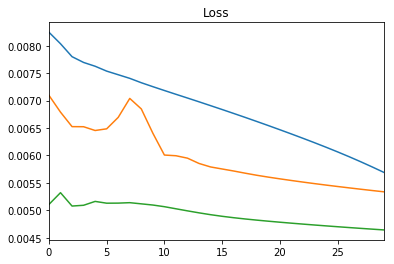

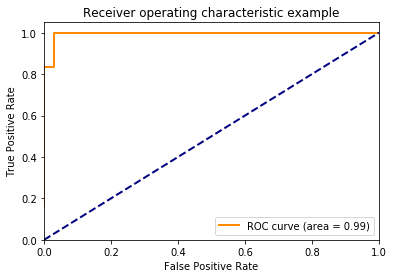

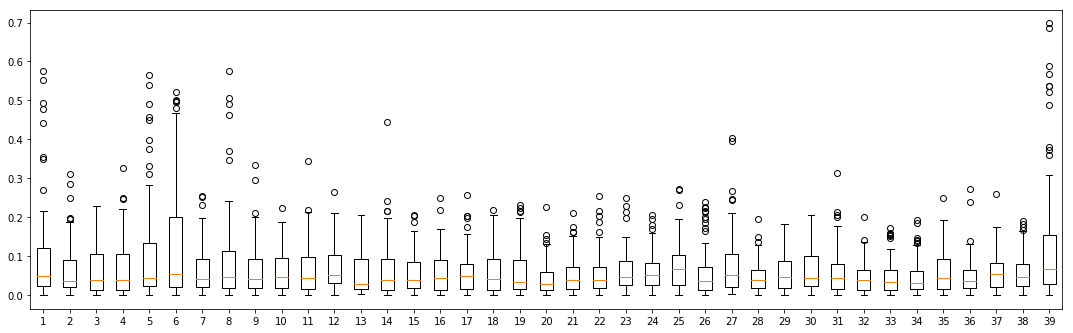

--- Online time: 28.86297345161438 seconds ---


In [28]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []
ein0 = []
aus0=[]
para_recorder = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
        
start_time = time.time()
for data in test_set_list:
        
        para_recorder.append([mu,sigma, threshold])
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})
        ein0.append(input_n.reshape(-1,))
        aus0.append(output_n.reshape(-1,))
        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,scores)).mean()]
        output += [scores.max()]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        e = [err.ravel()[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        for index,value in enumerate(pred):
            if value[value>threshold].size>=5: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                else:
                    #print("FP")
                    err_nbuf.append(e[index])
                    n_buf.append(df[index])
                    mu,sigma = update(err_nbuf,acc_size,mu,sigma)
                    mus.append(mu)
                    sigmas.append(sigma)
                    acc_size += step_num
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                else:
                    err_nbuf.append(e[index])
                    mu,sigma = update(err_nbuf,acc_size,mu,sigma)
                    mus.append(mu)
                    sigmas.append(sigma)
                    acc_size += step_num
                    #print("TN")
        count +=1
        

        
        if len(n_buf)>=9 and len(a_buf)>=1:
            print("retrain before %d batch"%count)
            print
            loss_list_all=[]

            datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            

            
            #mu,sigma,threshold = update_parameter(err_nbuf,err_abuf,acc_size,mu,sigma,threshold)
            mu,sigma = update(err_nbuf,acc_size,mu,sigma,retraining=True)
            normal_score = []
            abnormal_score = []
            
            for val in validation_list_n:
                (ein,aus) = sess.run([input_,output_], {p_input: val,p_is_training :False})
                
                err = abs(ein-aus).reshape(-1,elem_num)
        
                normal_score +=scoring(err,mu,sigma)
            
            for val_a in validation_list_a:
                (ein,aus) = sess.run([input_,output_], {p_input: val_a,p_is_training :False})
                
                err = abs(ein-aus).reshape(-1,elem_num)
        
                abnormal_score +=scoring(err,mu,sigma)
            threshold = get_threshold(normal_score, abnormal_score)
        
            #print("New parameters: ",mu,sigma,threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 5.5)
ax.boxplot(box)

plt.show()
print("--- Online time: %s seconds ---" % (time.time() - start_time))
            

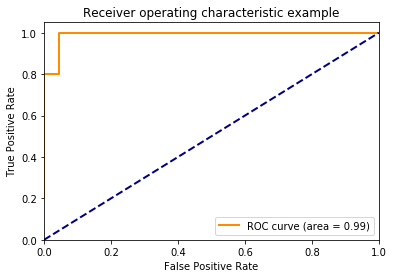

In [31]:
fpr, tpr, thresholds = metrics.roc_curve(expert[:27], output[:27], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
plot_roc(fpr,tpr,auc)

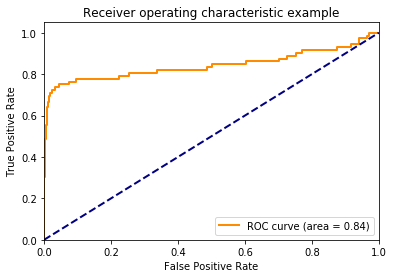

In [16]:
foo = pd.Series(np.array(all_scores).ravel())
fpr, tpr, thresholds = metrics.roc_curve(labels[13:], foo[13:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

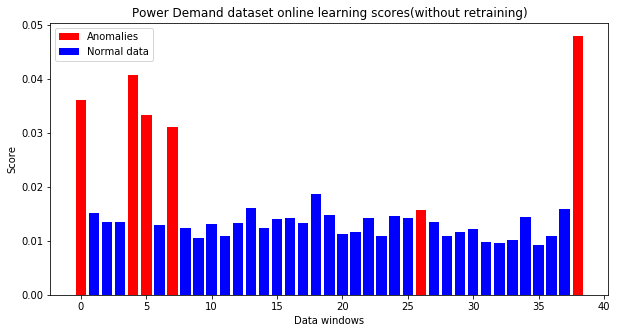

In [89]:
plt.figure(figsize=(10,5))
#barlist = plt.bar(range(len(output)),output)
#for x in anomaly_index:
#    barlist[x].set_color('r')
bar1 = plt.bar(anomaly_index,pd.Series(output)[anomaly_index],color='r')
bar2 = plt.bar(normal_index,pd.Series(output)[normal_index],color='b')
plt.legend([bar1,bar2], ["Anomalies","Normal data"])

plt.xlabel("Data windows")
plt.ylabel("Score")
plt.title("Power Demand dataset online learning scores(without retraining)")
plt.show()

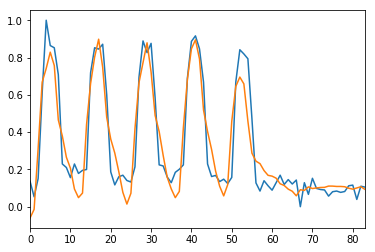

In [94]:
pd.Series(ein0[9]).plot()
pd.Series(aus0[9]).plot()


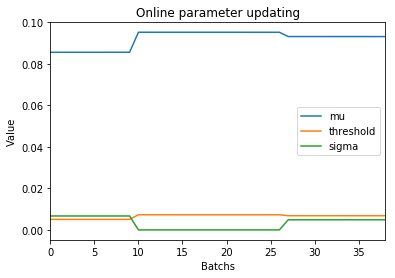

In [138]:
pd.DataFrame(para_recorder,columns={"mu","sigma","threshold"}).plot()
plt.title("Online parameter updating")
plt.xlabel("Batchs")
plt.ylabel("Value")
plt.show()

TP
FP
FP
FP
TP
TP
FP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP


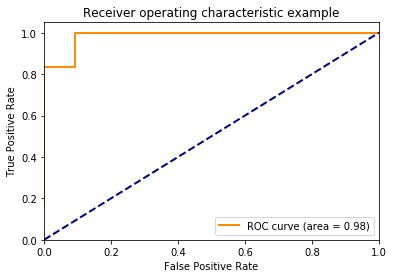

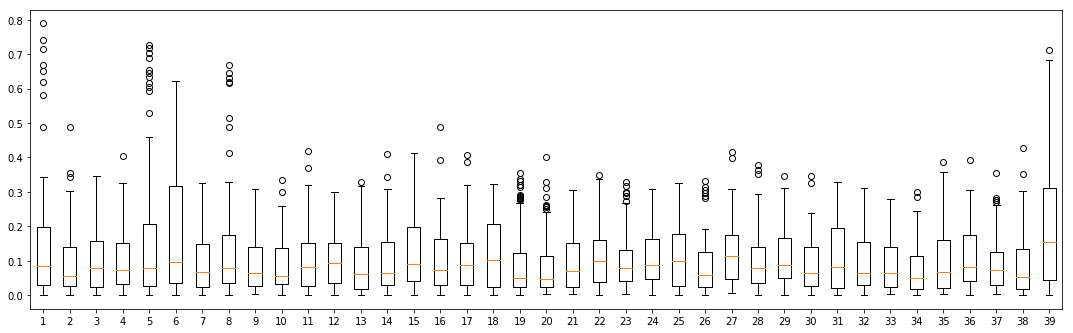

--- Online time: 1.3669955730438232 seconds ---


In [23]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []

ein = []
aus = []
start_time = time.time()

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})
        ein.append(input_n.reshape(-1,))
        aus.append(output_n.reshape(-1,))
        
        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,scores)).mean()]
        output += [scores.max()]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        e = [err.ravel()[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        for index,value in enumerate(pred):
            if value[value>threshold].size>=5: 
                if label[index] == "anomaly":
                    print("TP")                 
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                else:
                    print("FP")
                    err_nbuf.append(e[index])
                    n_buf.append(df[index])
                    mu,sigma = update(err_nbuf,acc_size,mu,sigma)
                    mus.append(mu)
                    sigmas.append(sigma)
                    acc_size += step_num
            else:               
                if label[index] == "anomaly":             
                    print("FN")
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                else:
                    err_nbuf.append(e[index])
                    mu,sigma = update(err_nbuf,acc_size,mu,sigma)
                    mus.append(mu)
                    sigmas.append(sigma)
                    acc_size += step_num
                    print("TN")
        count +=1
        

fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 5.5)
ax.boxplot(box)

plt.show()
print("--- Online time: %s seconds ---" % (time.time() - start_time))


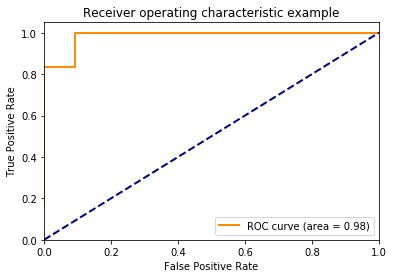

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
plot_roc(fpr,tpr,auc)

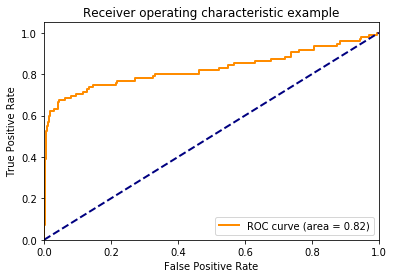

In [15]:
foo = pd.Series(np.array(all_scores).ravel())
fpr, tpr, thresholds = metrics.roc_curve(labels[1:], foo[1:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

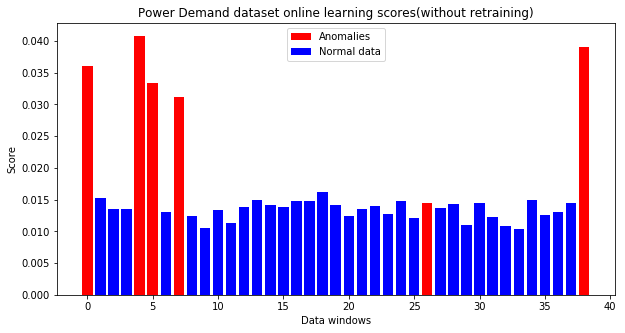

In [99]:
plt.figure(figsize=(10,5))
#barlist = plt.bar(range(len(output)),output)
#for x in anomaly_index:
#    barlist[x].set_color('r')
bar1 = plt.bar(anomaly_index,pd.Series(output)[anomaly_index],color='r')
bar2 = plt.bar(normal_index,pd.Series(output)[normal_index],color='b')
plt.legend([bar1,bar2], ["Anomalies","Normal data"])

plt.xlabel("Data windows")
plt.ylabel("Score")
plt.title("Power Demand dataset online learning scores(without retraining)")
plt.show()

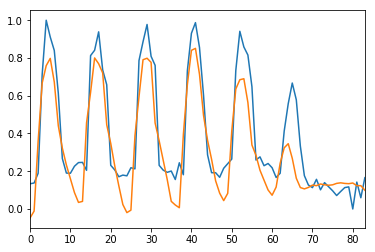

In [55]:
pd.Series(ein[26]).plot()
pd.Series(aus[26]).plot()


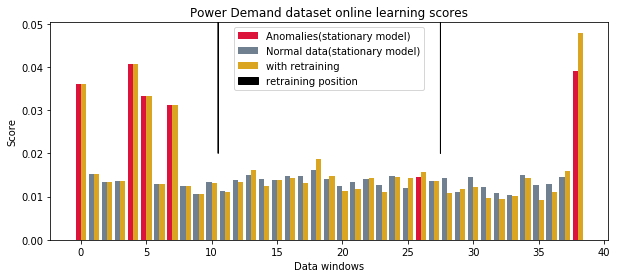

In [130]:
plt.figure(figsize=(10,4))
#barlist = plt.bar(range(len(output)),output)
#for x in anomaly_index:
#    barlist[x].set_color('r')
bar1 = plt.bar(np.array(anomaly_index)-0.2,pd.Series(output)[anomaly_index],color='crimson',width=0.4)
bar2 = plt.bar(np.array(normal_index)-0.2,pd.Series(output)[normal_index],color='slategray',width=0.4)

bar3 = plt.bar(np.arange(len(my_tmp))+0.2,pd.Series(my_tmp),color='goldenrod',width=0.4)
#bar4 = plt.bar(normal_index,pd.Series(my_tmp)[normal_index],color='y')
arrow = plt.arrow(10.5,0.02,0,0.03,color="black")
plt.arrow(27.5,0.02,0,0.03)
plt.legend([bar1,bar2,bar3,arrow], ["Anomalies(stationary model)","Normal data(stationary model)","with retraining","retraining position"])

plt.xlabel("Data windows")
plt.ylabel("Score")
plt.title("Power Demand dataset online learning scores")
plt.show()